## 1.4 Loss Panelty

이번 실습에서는 Loss Panelty를 이용해 정규화하는 방법에 대해 알아보고자 합니다. 우선 대부분은 Early Stop 실습과 동일하게 진행해줍니다. 

In [1]:
import math
import random 

import tensorflow as tf
import numpy as np 

seed = 1
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28])
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)
    
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)        
y_hat = layer

Loss Panelty를 이용한 정규화는 loss 함수를 변화시킴으로써 정규화 효과를 얻는 방식을 말합니다. 우리는 이번 실습에서 가장 자주 쓰이는 loss panelty 중 하나인 L2 panelty(weight decay)를 사용해보고자 합니다. 

In [2]:
y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
regularization_loss = tf.add_n([tf.reduce_sum(tf.square(w)) for w in weights])
loss = cross_entropy_loss + 0.001 * regularization_loss

다시 다른 부분들은 이전 실습과 동일하게 진행해 줍니다.

In [3]:
accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0
weight_values = []
for epoch_idx in range(1, 1000 + 1):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
            weight_values = session.run(weights)
            
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(final_test_accuracy)

10 1.6889 2.0048 1.9541 0.9550 0.8200 0.8492
20 1.4178 1.8514 1.7703 0.9960 0.8800 0.8745
30 1.2858 1.7532 1.6579 1.0000 0.8900 0.8802
40 1.1844 1.6616 1.5609 1.0000 0.8900 0.8840
50 1.0942 1.5726 1.4739 1.0000 0.8800 0.8841
60 1.0126 1.4846 1.3936 1.0000 0.8900 0.8844
70 0.9383 1.4027 1.3199 1.0000 0.9000 0.8855
80 0.8704 1.3362 1.2519 1.0000 0.9000 0.8852
90 0.8083 1.2797 1.1900 1.0000 0.9000 0.8841
100 0.7514 1.2228 1.1337 1.0000 0.8900 0.8832
110 0.6991 1.1749 1.0822 1.0000 0.9000 0.8828
120 0.6511 1.1317 1.0333 1.0000 0.9000 0.8831
130 0.6070 1.0868 0.9885 1.0000 0.9000 0.8824
140 0.5664 1.0466 0.9472 1.0000 0.9000 0.8825
150 0.5292 1.0066 0.9095 1.0000 0.8900 0.8827
160 0.4950 0.9699 0.8750 1.0000 0.8800 0.8819
170 0.4636 0.9346 0.8438 1.0000 0.9000 0.8813
0.8855


88.05% -> 88.55% 로 성능이 0.5% 향상한 것을 확인할 수 있었습니다.

이제 최종 모델 파라미터의 각 element의 distribution을 확인해봅시다. 

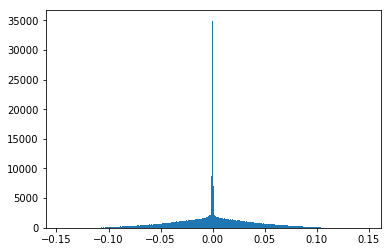

In [4]:
dist = np.concatenate([w.flatten() for w in weight_values], axis=None)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(dist, bins=1000)
plt.show()

### L1과 L2를 동시에 사용하는 정규화 panelty term을 디자인할 수도 있을 것입니다. L1이나 L2를 사용할 때, 각 weight matrix 별로 다른 람다값을 사용하면 더 좋은 성능을 가진 네트워크를 가질 수 있지만, 찾아야 하는 파라미터가 너무 많아져 practical하지 않습니다. 

### 연습 문제

Q1. 람다 값을 변경해보면서 test accuracy 와 weight distribution의 변화를 확인해보세요. 

Q2. L2정규화를 L1으로 바꿔보고, L1에 맞는 람다 값을 찾아보세요. 정규화를 이용해서 성능을 향상시킬 수 있는지, weight distribution에는 어떤 변화가 있는지 확인해봅시다.
(힌트는 [여기](01_04_loss_panelty_Q2_hint.txt)에서 확인하실 수 있습니다.)
(정답은 [여기](01_04_loss_panelty_Q2_answer.txt)에서 확인하실 수 있습니다.)

Q3. (도전과제) L1 정규화를 이용해 각 hidden layer의 적정 hidden unit 갯수를 찾아봅시다. 

주의사항! 코드를 수정한 이후에는 Kernel > Restart & Run All 을 통해 네트워크를 처음부터 다시 학습시켜 주세요. 

### 다음 실습

다음 [실습](01_05_hidden_layer_stabilization.ipynb)에서는 Hidden Layer의 statistics을 안정화시키는 방식에 대해서 배워보고자 합니다. 